## Loading datasets and Handling missing values

In [ ]:
# Installtion of libraries
import pandas as pd

# Load the datasets
load_history_df = pd.read_csv("Load_history.csv")
temperature_history_df = pd.read_csv("temperature_history.csv")
benchmark_df = pd.read_csv("Benchmark.csv")
weights_df = pd.read_csv("weights.csv")

# checking first 5 rows of the datasets
print(load_history_df.head())
print(temperature_history_df.head())
print(benchmark_df.head())
print(weights_df.head())


In [ ]:
# Description of the dataset
print(load_history_df.describe())
print(temperature_history_df.describe())
print(benchmark_df.describe())
print(weights_df.describe())

In [ ]:
# Datatypes of variables in dataset
print(load_history_df.dtypes)
print(temperature_history_df.dtypes)
print(benchmark_df.dtypes)
print(weights_df.dtypes)

In [ ]:
# Columns to be changed
Change_columns = load_history_df.columns[4:]

# Delete commas and convert datatypes to float
for i in Change_columns:
    load_history_df[i] = load_history_df[i].str.replace(',', '').astype(float)


In [ ]:
# Check for missing values
print("Missing values in Load History:", load_history_df.isnull().sum())

print("Missing values in Temperature History:", temperature_history_df.isnull().sum())

print("Missing values in Benchmark:", benchmark_df.isnull().sum())

print("Missing values in Weights:", weights_df.isnull().sum())

In [ ]:
# Interpolation of load_history_df dataset
load_history_df.interpolate(method='linear', inplace=True, limit_direction='both')
# Interpolation of temperature_history_df dataset
temperature_history_df.interpolate(method='linear', inplace=True, limit_direction='both')

# Drop rows with missing values in benchmark_df and weights_df
benchmark_df.dropna(inplace=True)
weights_df.dropna(inplace=True)

Merging datasets

In [ ]:
# Merging Load_history.csv and Benchmark.csv
benchmark_merge = pd.merge(load_history_df, benchmark_df,
                                 on=['zone_id', 'year', 'month', 'day'],
                                 suffixes=('_actual', '_benchmark'))

# Merging Load_history.csv and weights.csv
weights_merge = pd.merge(load_history_df, weights_df,
                               on=['zone_id', 'year', 'month', 'day'],
                               suffixes=('_load', '_weight'))
# Merging load_history_df and temperature_history_df
temperature_merge = pd.merge(load_history_df, temperature_history_df,
                                   on=['year', 'month', 'day'],
                                   suffixes=('_load', '_temp'))


## Exploratory Data Analysis

### Distribution of Load and temperature

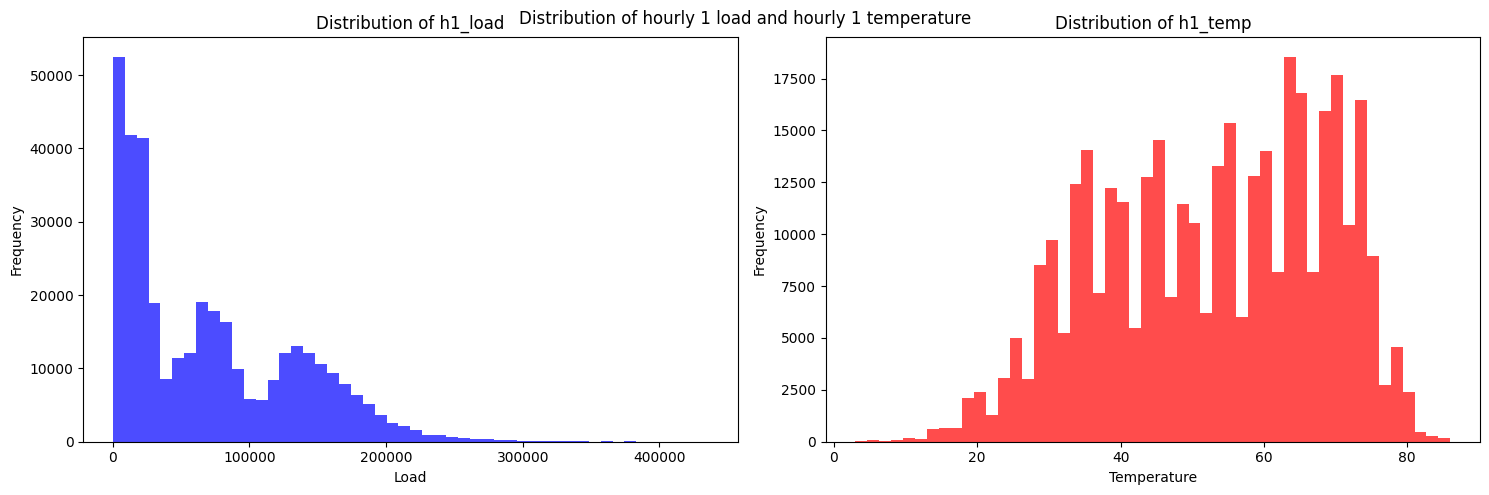

In [ ]:
# plot for distribution of hourly load vs horly temp
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(temperature_merge['h1_load'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of h1_load')
plt.xlabel('Load')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(temperature_merge['h1_temp'], bins=50, color='red', alpha=0.7)
plt.title('Distribution of h1_temp')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle("Distribution of hourly 1 load and hourly 1 temperature")
plt.show()


### Relationship between Load and Temperature

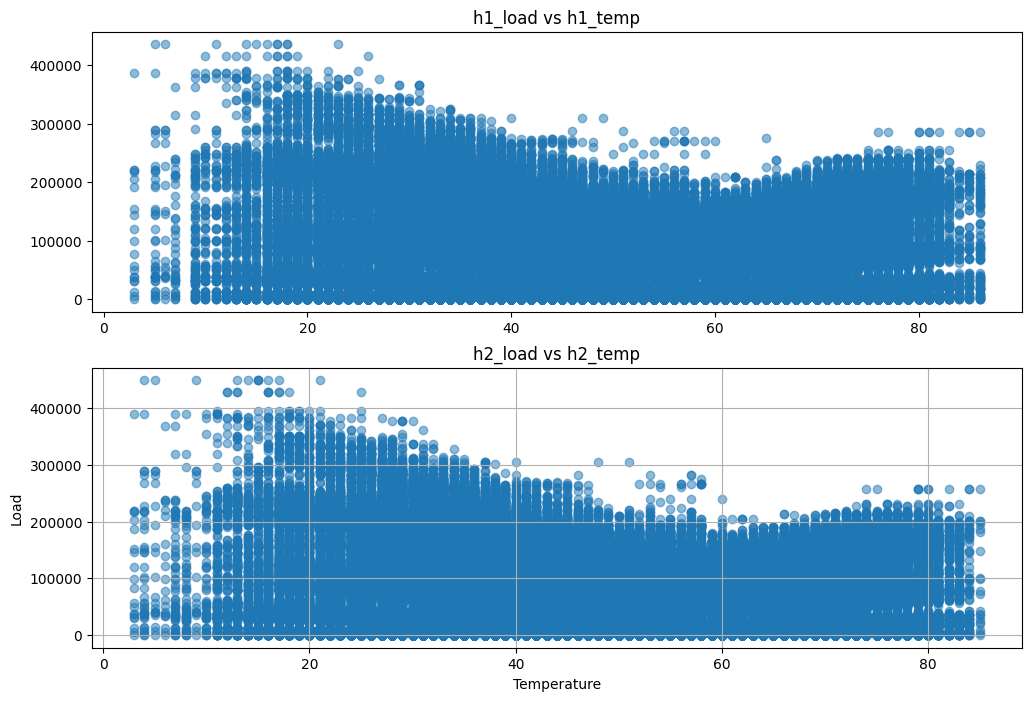

In [ ]:
# Plot for h1 load vs h1 temp
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.scatter(temperature_merge['h1_temp'], temperature_merge['h1_load'], alpha=0.5)
plt.title('h1_load vs h1_temp')
plt.subplot(2,1,2)
plt.scatter(temperature_merge['h2_temp'], temperature_merge['h2_load'], alpha=0.5)
plt.title('h2_load vs h2_temp')
plt.xlabel('Temperature')
plt.ylabel('Load')
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
l_columns = [col for col in temperature_merge.columns if "_load" in col]
t_columns = [col for col in temperature_merge.columns if "_temp" in col]

load_df = temperature_merge[l_columns]
temperature_df = temperature_merge[t_columns]


In [ ]:
# Finding correlations
correlations = []
for load_col, temp_col in zip(l_columns, t_columns):
    correlation = load_df[load_col].corr(temperature_df[temp_col])
    correlations.append(correlation)

correlation_df = pd.DataFrame({'Hour': [col.split('_')[0] for col in l_columns],
                               'Correlation': correlations}).set_index('Hour')
print(correlation_df)


      Correlation
Hour             
h1      -0.116662
h2      -0.144240
h3      -0.166242
h4      -0.182861
h5      -0.195137
h6      -0.196143
h7      -0.190783
h8      -0.175442
h9      -0.144630
h10     -0.098781
h11     -0.050527
h12     -0.007400
h13      0.027194
h14      0.052900
h15      0.065618
h16      0.068880
h17      0.056705
h18      0.026815
h19      0.008718
h20     -0.010508
h21     -0.018808
h22     -0.023516
h23     -0.050991
h24     -0.083415


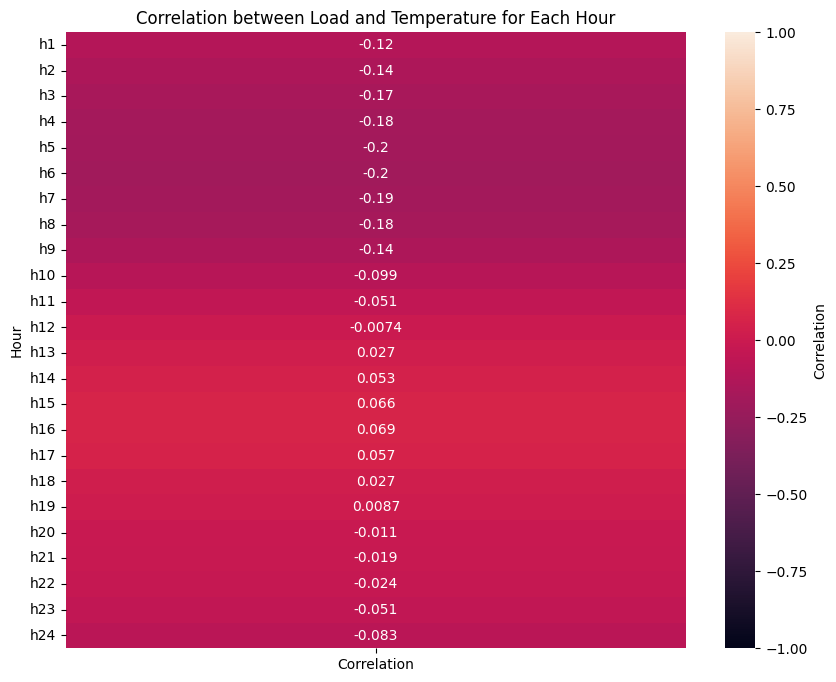

In [ ]:
# Heatmap for correlations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title("Correlation between Load and Temperature for Each Hour")
plt.show()


### Daily pattern

<ipython-input-13-3654acd7eea4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone1['date'] = pd.to_datetime(zone1[['year', 'month', 'day']])


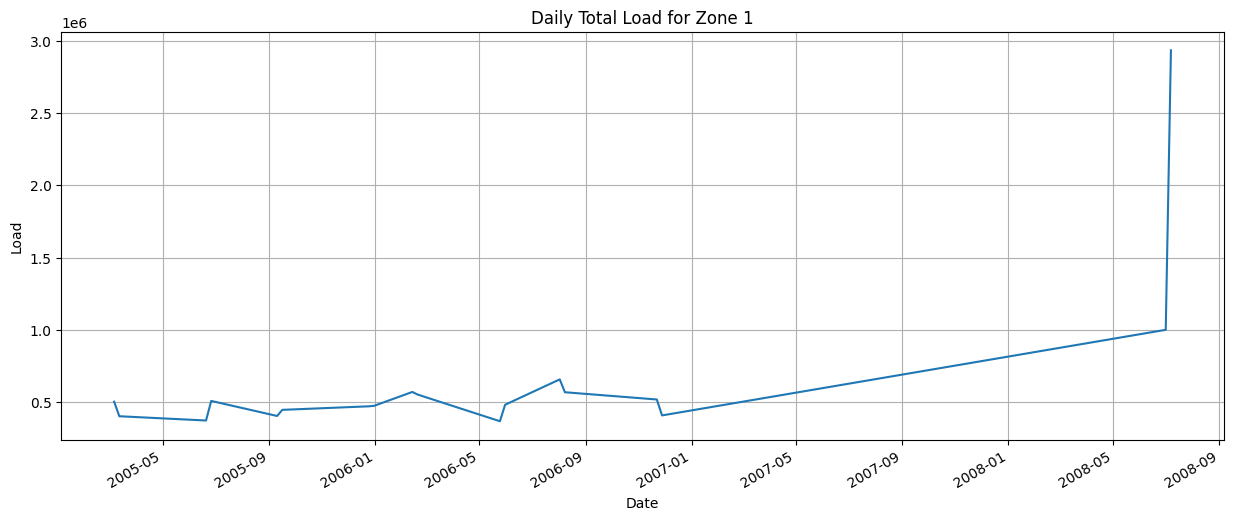

In [ ]:
# Zone 1 data
zone1 = weights_merge[weights_merge['zone_id'] == 1]
zone1['date'] = pd.to_datetime(zone1[['year', 'month', 'day']])
daily_load_zone1 = zone1.set_index('date').iloc[:, 4:28].sum(axis=1)

# Daily total load for zone 1 data
plt.figure(figsize=(15, 6))
daily_load_zone1.plot(title='Daily Total Load for Zone 1')
plt.ylabel('Load')
plt.xlabel('Date')
plt.grid(True)
plt.show()


## ARIMA

In [ ]:
# Load and temperature data for zone 1
zone1_load_df = load_history_df[load_history_df['zone_id'] == 1].copy()
zone1_temperature_df = temperature_history_df[temperature_history_df['station_id'] == 1].copy()


In [ ]:
# Merging datasets
merged_df = pd.merge(zone1_load_df, zone1_temperature_df, on=['year', 'month', 'day'], suffixes=('_load', '_temp'))


In [ ]:
# Convert the data to long format
merged1_df = pd.melt(merged_df, id_vars=['year', 'month', 'day'],
                         value_vars=[f"h{i}_load" for i in range(1, 25)] + [f"h{i}_temp" for i in range(1, 25)],
                         var_name='hour_type', value_name='value')

merged1_df['hour'] = merged1_df['hour_type'].str.extract('(\d+)').astype(int)
merged1_df['type'] = merged1_df['hour_type'].str.split('_').str[-1]
merged1_df.drop(columns='hour_type', inplace=True)

merged_long_df = merged1_df.pivot_table(index=['year', 'month', 'day', 'hour'],
                                            columns='type', values='value', aggfunc='first').reset_index()

# Create a datetime column
merged1_df['datetime'] = pd.to_datetime(merged_long_df[['year', 'month', 'day', 'hour']])

# Set index
merged1_df.set_index('datetime', inplace=True)
merged1_df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model with temperature as external factor
model = ARIMA(merged_long_df['load'], order=(1,1,1), exog=merged_long_df['temp'])
model_fit = model.fit()

# Forecast the next week
forecast = model_fit.forecast(steps=168, exog=merged_long_df['temp'].iloc[-168:])


In [ ]:
# display first 10 rows
forecast_df = pd.DataFrame({'Forecasted Load': forecast})
forecast_df.head(10)

,Forecasted Load
39432,25292.115499
39433,24077.419958
39434,23292.591967
39435,22877.123588
39436,22645.286644
39437,22502.503181
39438,22321.424055
39439,22179.662643
39440,22123.833261
39441,22061.272216


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

# Extracting values after forecasting
actual_values = merged_long_df['load'].iloc[-168:]

# RMSE value for ARIMA
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast_df['Forecasted Load']))


print("RMSE: " + str(rmse_arima))


RMSE: 7576.724788875158


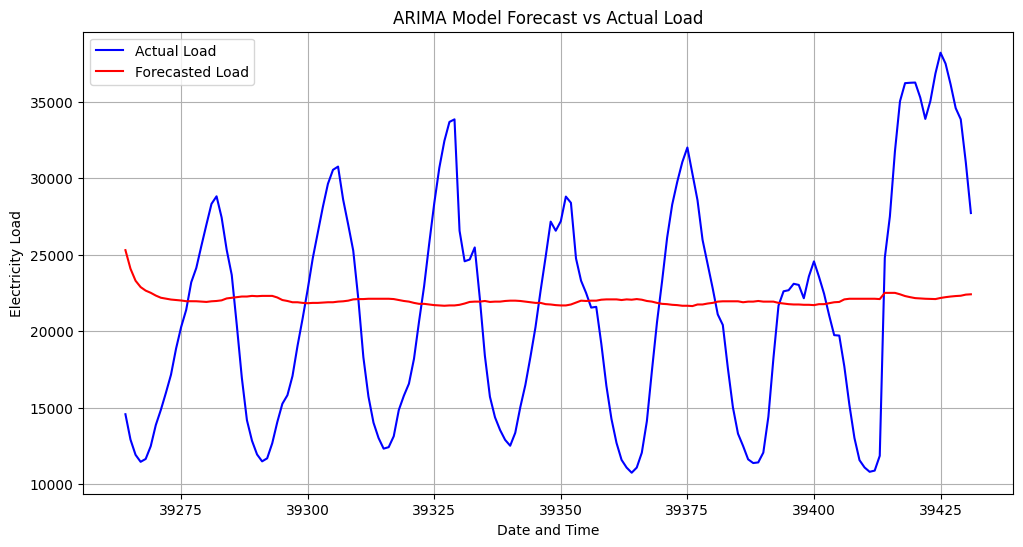

In [ ]:
# Plotting the actual vs. forecasted values
import matplotlib.pyplot as plt
forecast_index = actual_values.index
plt.figure(figsize=(12, 6))
plt.plot(forecast_index, actual_values, label='Actual Load', color='blue')
plt.plot(forecast_index, forecast_df['Forecasted Load'], label='Forecasted Load', color='red')

plt.title('ARIMA Model Forecast vs Actual Load')
plt.xlabel('Date and Time')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)
plt.show()


## Regression models

In [ ]:
from sklearn.model_selection import train_test_split
X = merged_long_df[['temp']]
y = merged_long_df['load']
# Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=168, shuffle=False)

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = regressor.predict(X_test)
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

# Calculating the RMSE for the Linear Regression model's predictions
rmse_regression = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the RMSE
print("RMSE (Linear Regression):", rmse_regression)

RMSE (Linear Regression): 8183.580887190065


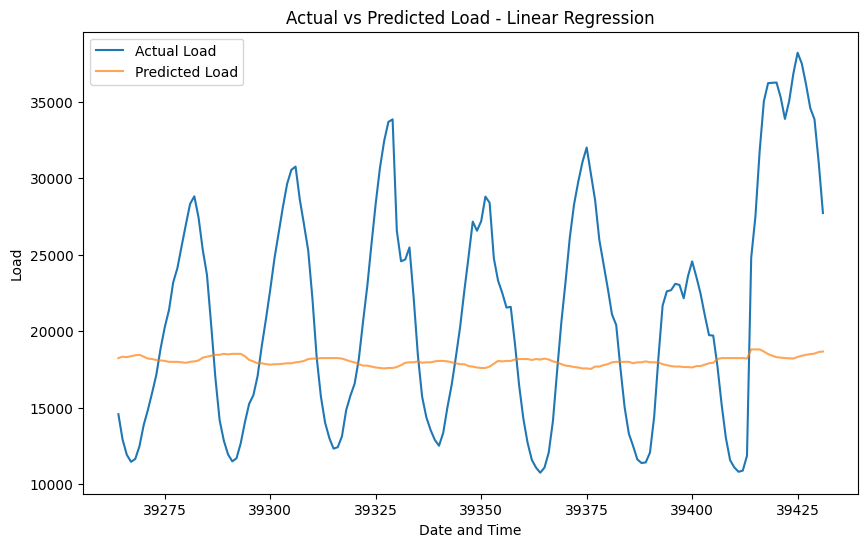

In [ ]:
# Plotting actual vs predicted load
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Load')
plt.plot(y_test.index, y_pred, label='Predicted Load', alpha=0.7)
plt.title('Actual vs Predicted Load - Linear Regression')
plt.xlabel('Date and Time')
plt.ylabel('Load')
plt.legend()
plt.show()

## SVM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
zone1_load_df = load_history_df[(load_history_df['zone_id'] == 1) & (load_history_df['year'] == 2008) & (load_history_df['month'] == 1)]
zone1_temperature_df = temperature_history_df[(temperature_history_df['station_id'] == 1) & (temperature_history_df['year'] == 2008) & (temperature_history_df['month'] == 1)]

# Merge load and temperature datasets
merged_df = pd.merge(zone1_load_df, zone1_temperature_df, on=['year', 'month', 'day'], suffixes=('_load', '_temp'))

# Change data to long format
merged_long_df = pd.melt(merged_df, id_vars=['year', 'month', 'day'],
                         value_vars=[f"h{i}_load" for i in range(1, 25)] + [f"h{i}_temp" for i in range(1, 25)],
                         var_name='hour_type', value_name='value')

# Extract hour and type
merged_long_df['hour'] = merged_long_df['hour_type'].str.extract('(\d+)').astype(int)
merged_long_df['type'] = merged_long_df['hour_type'].str.split('_').str[-1]
merged_long_df.drop(columns='hour_type', inplace=True)

# Pivot table
merged_long_df = merged_long_df.pivot_table(index=['year', 'month', 'day', 'hour'],
                                            columns='type', values='value', aggfunc='first').reset_index()
merged_long_df['datetime'] = pd.to_datetime(merged_long_df[['year', 'month', 'day', 'hour']])
merged_long_df.set_index('datetime', inplace=True)
merged_long_df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Feature and target fixing
X = merged_long_df[['temp']]
y = merged_long_df['load']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Calculate the RMSE
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for SVM model:", rmse_svm)


RMSE for SVM model: 4547.586096089234


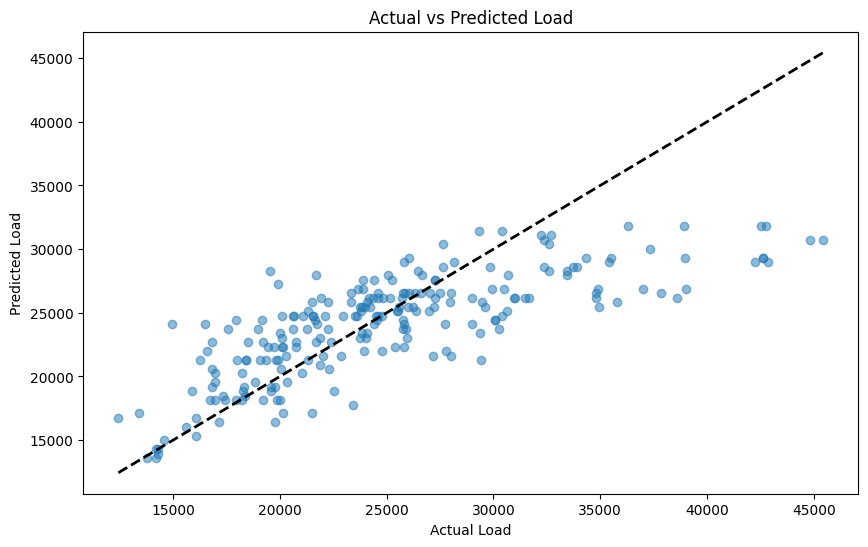

In [ ]:
# Actual vs Predicted Load
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Load')
plt.ylabel('Predicted Load')
plt.title('Actual vs Predicted Load')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

## Random forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
X = merged_long_df[['temp']]
y = merged_long_df['load']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE (Random Forest):", rmse_rf)



RMSE (Random Forest): 4116.043086919134


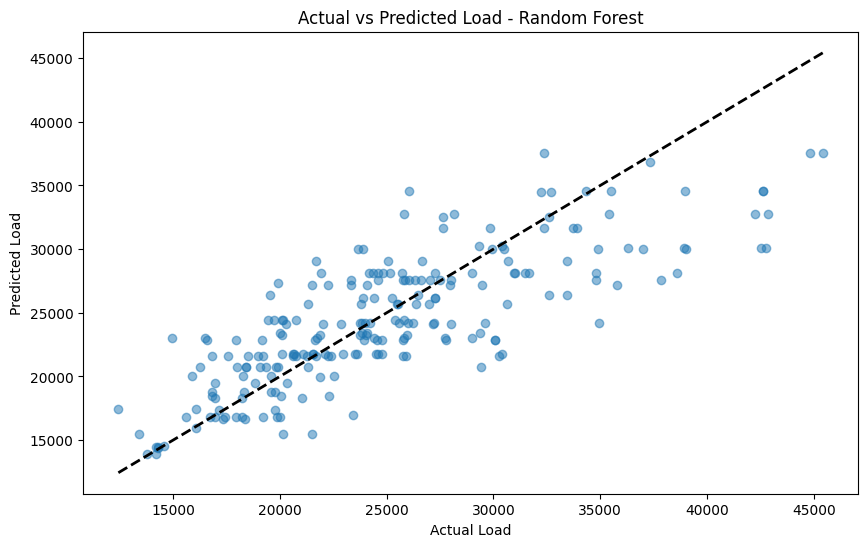

In [ ]:
# Creating a scatter plot for actual vs predicted load
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.title('Actual vs Predicted Load - Random Forest')
plt.xlabel('Actual Load')
plt.ylabel('Predicted Load')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Line for perfect predictions
plt.show()


## Artificial Neural Network

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
X = merged_long_df[['temp']]
y = merged_long_df['load']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the ANN model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(X_train, y_train, epochs=100, batch_size=32)
y_pred_ann = ann_model.predict(X_test)

# Calculate RMSE
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print("RMSE (ANN):", rmse_ann)


Epoch 1/100
17/17 [==============================] - 1s 4ms/step - loss: 616618624.0000
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 616589184.0000
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 616540096.0000
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 616454208.0000
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 616310656.0000
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 616088256.0000
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 615763008.0000
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 615308224.0000
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 614695616.0000
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss: 613896896.0000
Epoch 11/100
17/17 [==============================] - 0s 5ms/step - loss: 612879744.0000
Epoch 12/100
17/17 [==========

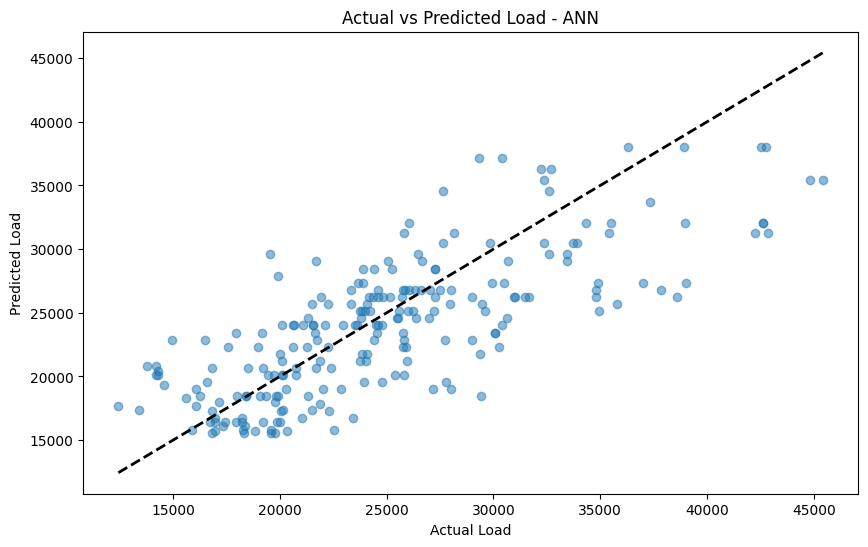

In [ ]:
# Creating a scatter plot for actual vs predicted load
import matplotlib.pyplot as plt
y_pred_ann_flat = y_pred_ann.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ann_flat, alpha=0.5)
plt.title('Actual vs Predicted Load - ANN')
plt.xlabel('Actual Load')
plt.ylabel('Predicted Load')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Line for perfect predictions
plt.show()

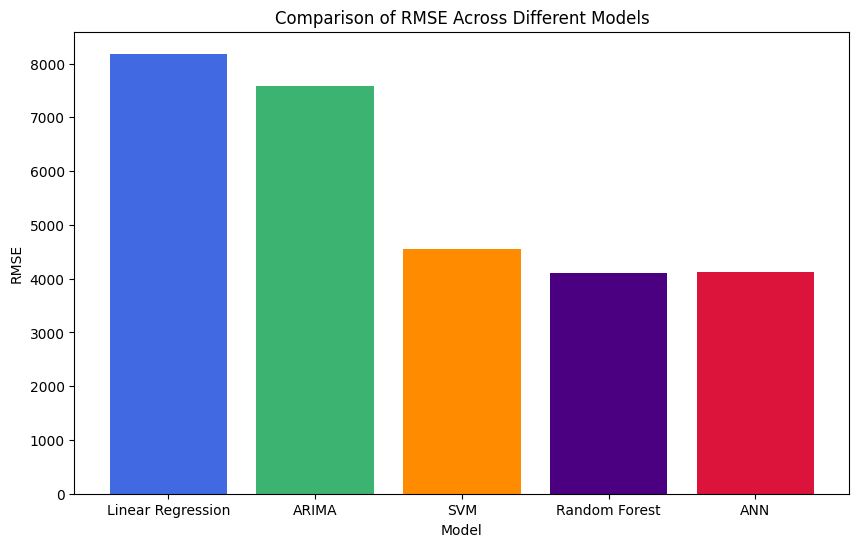

In [ ]:
# Creating the bar chart
import matplotlib.pyplot as plt

rmse_values = {
    'Linear Regression': 8183.580887190065,
    'ARIMA': 7576.724788875158,
    'SVM': 4547.586096089234,
    'Random Forest': 4101.683715412063,
    'ANN': 4117.146259566994
}

models = list(rmse_values.keys())
rmse = list(rmse_values.values())


plt.figure(figsize=(10, 6))
plt.bar(models, rmse, color=['royalblue', 'mediumseagreen', 'darkorange', 'indigo', 'crimson'])
plt.title('Comparison of RMSE Across Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()
